In [1]:
import tensorflow as tf
from tensorflow import keras

print("TensorFlow version:", tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time

from IPython import display

TensorFlow version: 2.11.0


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
discriminator = tf.keras.Sequential(
    [
        keras.Input(shape=(784,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dense(256, activation='relu'),
        # tf.keras.layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,353
Trainable params: 52,353
Non-trainable params: 0
_________________________________________________________________


In [7]:
latent_dim = 256

generator = tf.keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(512, activation='relu'),
        # tf.keras.layers.Dense(256, activation='relu'),
        layers.Dense(784, activation='sigmoid'),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_4 (Dense)             (None, 784)               402192    
                                                                 
Total params: 533,776
Trainable params: 533,776
Non-trainable params: 0
_________________________________________________________________


In [8]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}
    
    def predict_on_batch(self, x):
      return self.generator(x)
    
    def predict_step(self, data):
      return self.generator(data)

In [9]:
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 784))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=8192).batch(batch_size)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.MeanSquaredError(),
    # loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(dataset.take(100), epochs=1)

100/100 [==============================] - 2s 9ms/step - d_loss: 0.0920 - g_loss: 0.6359


In [10]:
def generate_images():
  batch_size = 16

  fig = plt.figure(figsize=(4,4))

  for i in range(batch_size):
      prediction = gan.predict(tf.random.normal(shape=(1, latent_dim)), verbose=0).reshape(28, 28)
      plt.subplot(4, 4, i+1)
      plt.imshow(prediction[:, :] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

In [11]:
def train_images():
  batch_size = 16

  fig = plt.figure(figsize=(4,4))

  for i in range(batch_size):
      plt.subplot(4, 4, i+1)
      plt.imshow(x_train[i, :, :] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

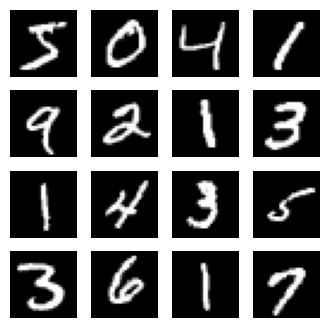

In [12]:
train_images()

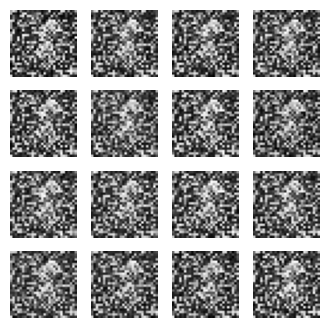

In [13]:
generate_images()

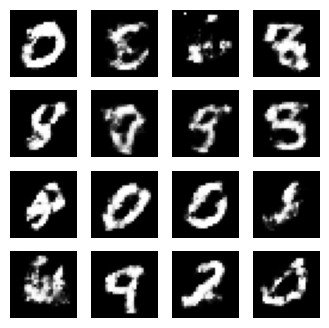

Epoch 1/10
69/69 [==============================] - 5s 75ms/step - d_loss: 0.1584 - g_loss: 0.5541
Epoch 2/10
69/69 [==============================] - 5s 73ms/step - d_loss: 0.1497 - g_loss: 0.5670
Epoch 3/10
54/69 [======================>.......] - ETA: 1s - d_loss: 0.1607 - g_loss: 0.5490

KeyboardInterrupt: 

In [14]:
batch_size = 1024

dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=8192).batch(batch_size)

for _ in range(500):
    gan.fit(dataset.take(10000), epochs=10)
    display.clear_output(wait=True)
    generate_images()

In [15]:
discriminator.save('mnist-v3/discriminator')
generator.save('mnist-v3/generator')

INFO:tensorflow:Assets written to: mnist-v3/discriminator\assets
INFO:tensorflow:Assets written to: mnist-v3/generator\assets


In [ ]:
dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)>